In [1]:
# all required libraries below
%pip install numpy --quiet
%pip install tonic --quiet
%pip install matplotlib --quiet
%pip install snntorch --quiet
%pip install torch --quiet
%pip install Lempel-Ziv-Complexity --quiet


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# All imports go here
import numpy as np
import numpy.lib.recfunctions as rf
import tonic
import matplotlib.pyplot as plt
from IPython.display import HTML
import torch
import torch.nn as nn
import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import utils
from lempel_ziv_complexity import lempel_ziv_complexity

/home/gauravgupta/CMPM118/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


In [ ]:
dataset_path = '/home/gauravgupta/CMPM118/data'
w,h=16,16
n_frames=10

transforms = tonic.transforms.Compose([
    tonic.transforms.Denoise(filter_time=10000), # removes outlier events with inactive surrounding pixels for 10ms
    tonic.transforms.Downsample(sensor_size=tonic.datasets.DVSGesture.sensor_size, target_size=(w,h)), # downsampling image
    tonic.transforms.ToFrame(sensor_size=(w,h,2), n_time_bins=n_frames), # n_frames frames per trail
])

train2 = tonic.datasets.DVSGesture(save_to=dataset_path, transform=transforms, train=True)
test2 = tonic.datasets.DVSGesture(save_to=dataset_path, transform=transforms, train=False)

cache_root = f"/home/gauravgupta/CMPM118/data/dvsgesture/{w}x{h}_T{n_frames}"
cached_train = tonic.DiskCachedDataset(train2, cache_path=f"{cache_root}/train")
cached_test  = tonic.DiskCachedDataset(test2,  cache_path=f"{cache_root}/test")



In [5]:
# This is used to figure out how many fully connected neurons need to be present in the last layer. This number depends on the w and h values. 

test_input = torch.zeros((1, 2, w, h))  # 2 polarity channels
x = nn.Conv2d(2, 8, 3)(test_input)
x = nn.MaxPool2d(2)(x)
print("Output shape before flatten:", x.shape)
print("Flattened size:", x.numel())
flattenedSize = x.numel()


Output shape before flatten: torch.Size([1, 8, 15, 15])
Flattened size: 1800


In [6]:
grad = snn.surrogate.fast_sigmoid(slope=25) # surrogate.atan()
beta = 0.15

net = nn.Sequential(
    nn.Conv2d(2, 8, 3), # in_channels, out_channels, kernel_size
    nn.MaxPool2d(2),
    snn.Leaky(beta=beta, spike_grad=grad, init_hidden=True),
    nn.Flatten(),
    nn.Linear(flattenedSize, 11),
    snn.Leaky(beta=beta, spike_grad=grad, init_hidden=True, output=True)
).to(device)

def forward_pass(net, data):
    spk_rec = []
    snn.utils.reset(net)  # resets hidden states for all LIF neurons in net
    for step in range(data.size(0)): # data.size(0) = number of time steps
        spk_out, mem_out = net(data[step].to(device))
        spk_rec.append(spk_out)
    return torch.stack(spk_rec)

optimizer = torch.optim.Adam(net.parameters(), lr=0.0001, betas=(0.9, 0.999))
loss_fn = SF.mse_count_loss(correct_rate=1.2, incorrect_rate=0.1)

loss_hist = []
acc_hist = []
test_acc_hist = []

In [7]:
def validate_model():
    correct, total = 0, 0  
    for batch, (data, targets) in enumerate(iter(test_loader)): 
        data, targets = data.to(device), targets.to(device) # [n_frames, batch, polarity, x-pos, y-pos] [batch] 
        spk_rec = forward_pass(net, data)         
        correct += SF.accuracy_rate(spk_rec, targets) * data.shape[0]
        total += data.shape[0]
    return correct/total

In [8]:
num_epochs = 60
cnt = 0
active_cores = 3

train_loader = torch.utils.data.DataLoader(cached_train, batch_size=64, shuffle=True, num_workers = active_cores, drop_last=True, 
                                           collate_fn=tonic.collation.PadTensors(batch_first=False))
test_loader = torch.utils.data.DataLoader(cached_test, batch_size=32, shuffle=True, num_workers = active_cores, drop_last=True, 
                                          collate_fn=tonic.collation.PadTensors(batch_first=False))

for epoch in range(num_epochs):
    for batch, (data, targets) in enumerate(iter(train_loader)):
        data = data.to(device)
        targets = targets.to(device)

        net.train()
        # propagating one batch through the network and evaluating loss
        spk_rec = forward_pass(net, data)
        loss = loss_fn(spk_rec, targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss.item())

        acc = SF.accuracy_rate(spk_rec, targets)
        acc_hist.append(acc)

        if cnt % 5 == 0:
            print(f"Epoch {epoch}, Iteration {batch} \nTrain Loss: {loss.item():.2f}")
            print(f"Train Accuracy: {acc * 100:.2f}%")
            test_acc = validate_model()            
            test_acc_hist.append(test_acc)
            print(f"Test Accuracy: {test_acc * 100:.2f}%\n")

        cnt+=1

Epoch 0, Iteration 0 
Train Loss: 1.40
Train Accuracy: 9.38%
Test Accuracy: 9.77%

Epoch 0, Iteration 5 
Train Loss: 1.40
Train Accuracy: 7.81%
Test Accuracy: 11.72%

Epoch 0, Iteration 10 
Train Loss: 1.36
Train Accuracy: 14.06%
Test Accuracy: 17.19%

Epoch 0, Iteration 15 
Train Loss: 1.23
Train Accuracy: 28.12%
Test Accuracy: 17.58%

Epoch 1, Iteration 4 
Train Loss: 1.20
Train Accuracy: 25.00%
Test Accuracy: 22.27%

Epoch 1, Iteration 9 
Train Loss: 1.15
Train Accuracy: 20.31%
Test Accuracy: 25.78%

Epoch 1, Iteration 14 
Train Loss: 1.11
Train Accuracy: 23.44%
Test Accuracy: 30.47%

Epoch 2, Iteration 3 
Train Loss: 1.09
Train Accuracy: 29.69%
Test Accuracy: 31.64%

Epoch 2, Iteration 8 
Train Loss: 1.05
Train Accuracy: 26.56%
Test Accuracy: 30.86%

Epoch 2, Iteration 13 
Train Loss: 1.03
Train Accuracy: 31.25%
Test Accuracy: 28.12%

Epoch 3, Iteration 2 
Train Loss: 1.02
Train Accuracy: 31.25%
Test Accuracy: 31.25%

Epoch 3, Iteration 7 
Train Loss: 0.94
Train Accuracy: 43.75%
Te

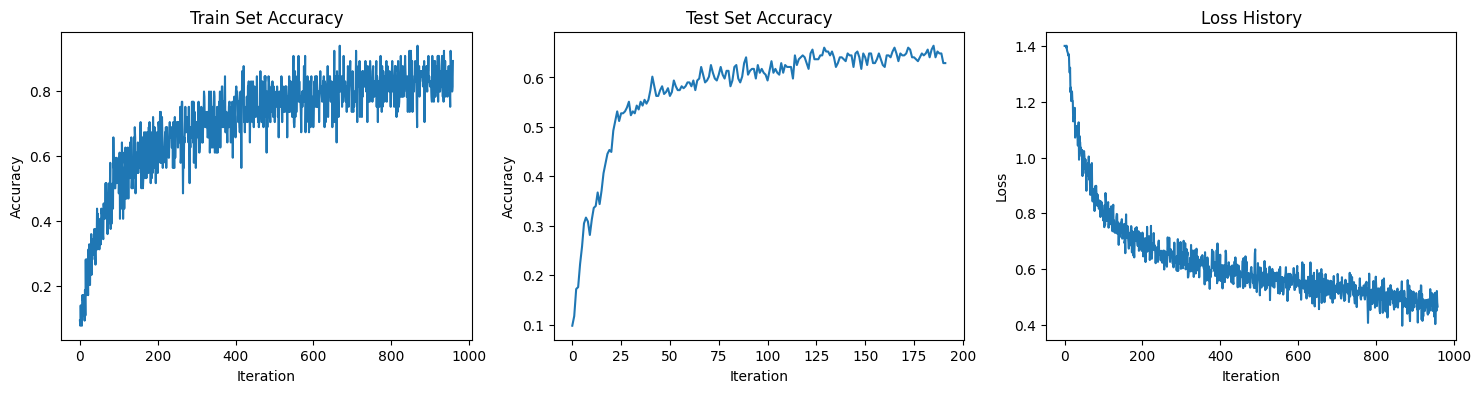

In [9]:
# this file basically takes the trained model from the call above, the acc_hist, test_acc_hist, and loss_hist, and puts it in a graph. 
# This file also saves BOTH the model and the graph along with the TRIAL NUMBER. This number is automatically updated. 



fig, axes = plt.subplots(1, 3, figsize=(18,4))

# Plot Train Accuracy
axes[0].plot(acc_hist)
axes[0].set_title("Train Set Accuracy")
axes[0].set_xlabel("Iteration")
axes[0].set_ylabel("Accuracy")

# Plot Test Accuracy
axes[1].plot(test_acc_hist)
axes[1].set_title("Test Set Accuracy")
axes[1].set_xlabel("Iteration")
axes[1].set_ylabel("Accuracy")

# Plot Training Loss
axes[2].plot(loss_hist)
axes[2].set_title("Loss History")
axes[2].set_xlabel("Iteration")
axes[2].set_ylabel("Loss")


# The part below automatically saves the model/accuracy graph in a unique file without you having to do anything

experiment_counter_file_path = "results/small/experiment_counter.txt"
with open(experiment_counter_file_path, "r") as f:
        num_str = f.read().strip()
        num = int(num_str)

num += 1

with open(experiment_counter_file_path, "w") as f:
    f.write(str(num))

model_save_path = f"results/small/models/Small_Take{num}_{w}x{h}_T{n_frames}.pth"
graph_save_path = f"results/small/graphs/Small_Take{num}_{w}x{h}_T{n_frames}.png"

torch.save(net.state_dict(), model_save_path) 
plt.savefig(graph_save_path)
plt.show()


